# VR-New-Hybrid

**Goal:** Look at the performance of the new hybrid model compared to 
1. Dedicated retrainings
2. The old hybrid


In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr
import uproot

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


**New hybrid $p_T$ spectrum**

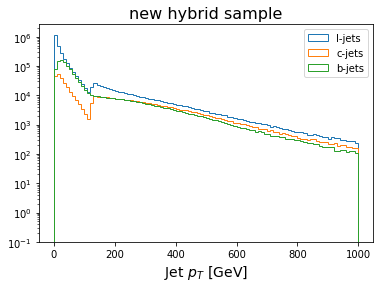

In [2]:
fname = "../../../public/FrancescoNtuples/mc16d_VR_hybrid_1.5TeV/VR_Hybrid_10_4_2019_1.root"
myTree = uproot.open(fname)["bTag_AntiKtVR30Rmax4Rmin02TrackJets"]

flat_jet_pt = np.concatenate(myTree.array(b'jet_pt'),axis=0) / 1000
flat_jet_flav = np.concatenate(myTree.array(b'jet_LabDr_HadF'),axis=0)

for pdg,flav in zip([0,4,5],['l','c','b']):
    plt.hist(flat_jet_pt[flat_jet_flav==pdg],
             bins=100,range=[0,1000],
             histtype='step',label=flav+'-jets',log=True)
       
plt.xlabel('Jet $p_T$ [GeV]',fontsize=14)
plt.legend()
plt.title('new hybrid sample', fontsize=16)
plt.savefig('../../figures/mc16d_VR_hybrid_1.5TeV_cut_125GeV/jet_pT.pdf')
plt.show()

### Get the discriminants and efficiencies

In [3]:
jetCollection = 'VR'
trJetCol = 'VR'
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"

nFeatures=13
figDir = '../../figures/'

In [4]:
leffs, ceffs, beffs, = [],[],[]
discs, labels = [],[]
ys, pts, etas = [],[],[]

for physicsSample, nTrks_te, miniJetTag in zip(['ttbar','Zprime_1.5TeV_2lead'],[15,25],['2m','1000k']):
        
    print('\nEvaluating on '+physicsSample)
        
    for trainPhysicsSample, Ntrain, nHidden, nTrks_tr, nClasses in \
        zip(['ttbar','Zprime_1.5TeV','hybrid_1.5TeV','hybrid_1.5TeV_cut_125GeV'],
            [int(2e6),int(3e6),int(4e6),int(3e6)], [200]*3+[300], [15,25,15,15],[4]*3+[3]):
        
        # Load in the sample for evaluation
        subDir = 'mc16d_{}_{}'.format(jetCollection,physicsSample)
        dataDir = '../../data/'+subDir
        scale_tag = "_{}_scale".format(trainPhysicsSample) if physicsSample != trainPhysicsSample else ""
        if trJetCol != jetCollection:
            scale_tag = '_' + trJetCol + scale_tag

        dataTagTest = "{}test_{}trks_{}_sd0_rev{}".format(miniJetTag,nTrks_te,vStr, scale_tag)

        f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
        f = h5py.File(f_name,"r")

        X = f['X_test'][:]
        y = f['y_test'][:]
        ix = f['ix_test'][:]

        f.close()

        # If we're evaluating the model that has been trained on 
        nTest = X.shape[0]
        if nTrks_te > nTrks_tr:
            # Restrict the # of tracks you're evaluating with
            X = X[:,:nTrks_tr,:]
        if nTrks_te < nTrks_tr:
            # Append 0s
            zeros = np.zeros((nTest,nTrks_tr-nTrks_te,nFeatures))
            X = np.concatenate((X,zeros),axis=1)

        # Also open the df so that you'll have access to the jet pt and eta
        jet_df = pd.read_hdf('{}/jet_{}test_{}trks_sd0_rev.h5'.format(dataDir,miniJetTag,nTrks_te), key='jet_df')

        # Only keep the events without taus, since these models were only trained w/ 
        # 3 output classes
        if trainPhysicsSample == 'hybrid_1.5TeV_cut_125GeV':
            notaus = (y != 3)
            X  = X[notaus]
            y  = y[notaus]
            ix = ix[notaus]
        
            pt = jet_df.pt.values[notaus]
            eta = jet_df.eta.values[notaus]
        
        else:
            pt = jet_df.pt.values
            eta = jet_df.eta.values
        
        # Load in the model
        modelDir = "../../models/mc16d_{}_{}".format(trJetCol,trainPhysicsSample)
        dataTagTrain = "{}train_{}trks_{}_sd0_rev".format(nJetsTag(Ntrain),nTrks_tr,vStr)
        m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, dataTag=dataTagTrain, 
                   loadModel=True,nClasses=nClasses)

        # Get the efficiencies
        tag = '_eval_{}_pt_10GeV'.format(physicsSample) if physicsSample != trainPhysicsSample else ''
        (leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True,
                                        figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)

        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)

        discs.append(d)
        labels.append('train {}, eval {}'.format(trainPhysicsSample,physicsSample))

        ys.append(y)
        pts.append(pt)
        etas.append(eta)



Evaluating on ttbar
Initialize method from myModel()
Loading previously trained LSTM
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file

Evaluating on Zprime_1.5TeV_2lead
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previous

## $t\bar{t}$ evaluation

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


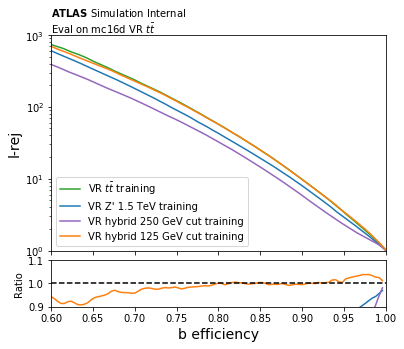

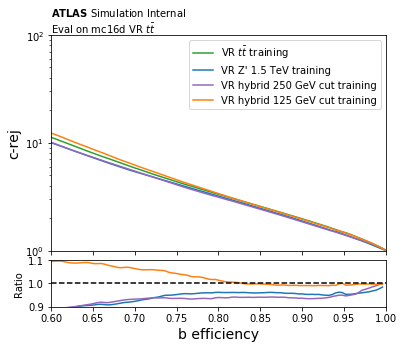

In [5]:
train_labels=['VR {} training'.format(x) for x in [r'$t\bar{t}$','Z\' 1.5 TeV','hybrid 250 GeV cut','hybrid 125 GeV cut']]

ntests = [np.sum(ys[0]==label) for label in range(3) ]

subDir = 'mc16d_VR_ttbar'
plotTag = 'rej_old_vs_new_hybrid'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR $t\bar{t}$"

colors = ['C2','C0','C4','C1']

plotROCRatio(beffs[:4], leffs[:4], 
             train_labels, rrange=(0.9,1.1),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROCRatio(beffs[:4], ceffs[:4], 
             train_labels, rrange=(0.9,1.1),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag)

l (0, 1000)
c (0, 20)
b (0, 1)


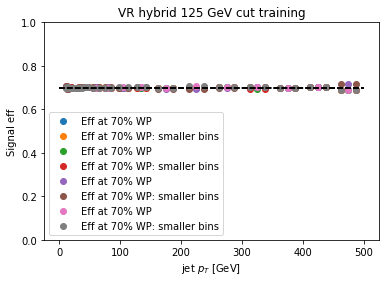

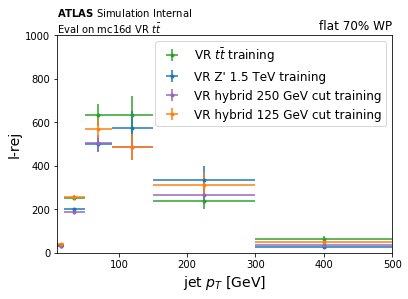

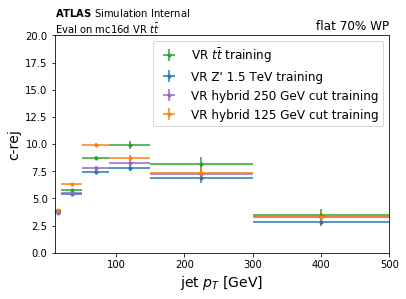

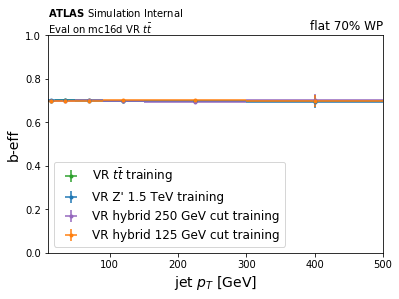

In [6]:
plotPtDependence(pts[:4],ys[:4],discs[:4], train_labels,
                 lrej_lim=(0,1000),crej_lim=(0,20),beff_lim=(0,1), verbose=False,
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.array([10,20, 50, 90, 150, 300, 500]),
                 eff_bins = np.array([10,12.5,15,17.5,20,30,40,50,70,90,120,150,200,250,300,350,400,450,500]),
                 figDir=figDir,subDir=subDir,tag=plotTag[4:])

**Comment from Rafael:** Zoom in on the first four bins, since that is where most of the $t\bar{t}$ VR sample is.

In [7]:
eff_bins = np.concatenate((np.arange(10,20,2.5),np.arange(20,155,5)))
eff_bins

array([ 10. ,  12.5,  15. ,  17.5,  20. ,  25. ,  30. ,  35. ,  40. ,
        45. ,  50. ,  55. ,  60. ,  65. ,  70. ,  75. ,  80. ,  85. ,
        90. ,  95. , 100. , 105. , 110. , 115. , 120. , 125. , 130. ,
       135. , 140. , 145. , 150. ])

l (0, 1500)
c (0, 20)
b (0, 1)


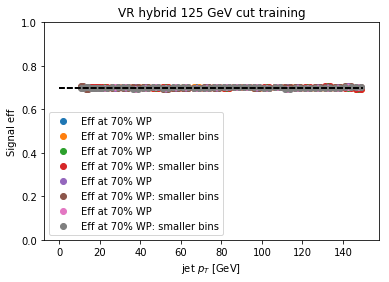

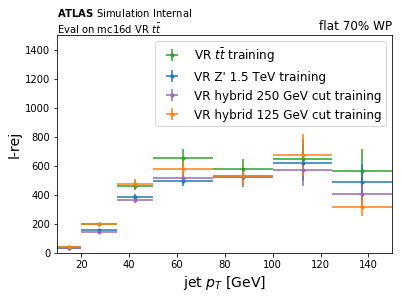

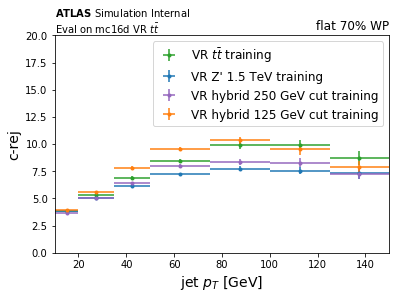

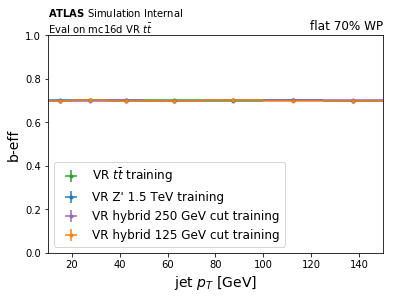

In [8]:
plotPtDependence(pts[:4],ys[:4],discs[:4], train_labels,
                 lrej_lim=(0,1500),crej_lim=(0,20),beff_lim=(0,1), verbose=False,
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.array([10, 20, 35, 50, 75, 100, 125, 150]),
                 eff_bins = eff_bins,
                 figDir=figDir,subDir=subDir,tag=plotTag[4:]+'_1250GeV_cutoff')

*Cool!* Next... let's look at the $\eta$ performance.

l (0, 850)
c (0, 10)
b (0, 1)


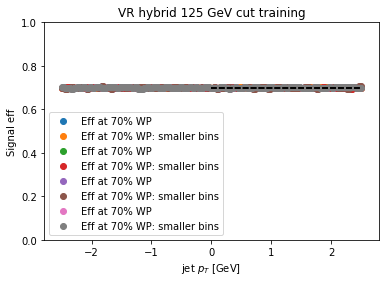

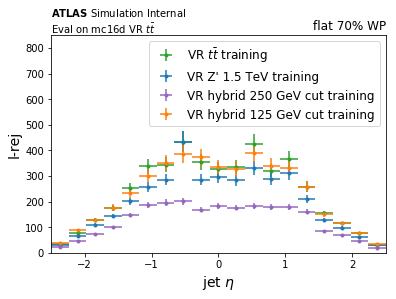

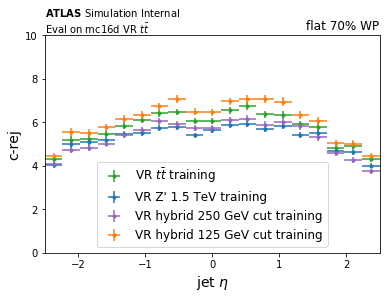

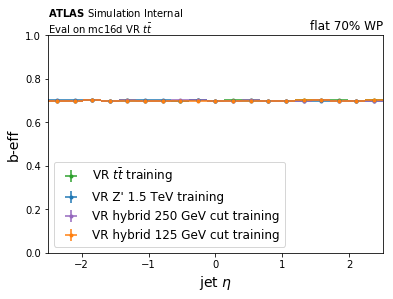

In [9]:
eta_min = -2.5
eta_max =  2.5

plotPtDependence(etas[:4],ys[:4],discs[:4], train_labels, xlabel='jet $\eta$',
                 lrej_lim=(0,850),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),verbose=False,
                 figDir=figDir,subDir=subDir,tag=plotTag[4:],
                 var='eta')

## Z' evaluation

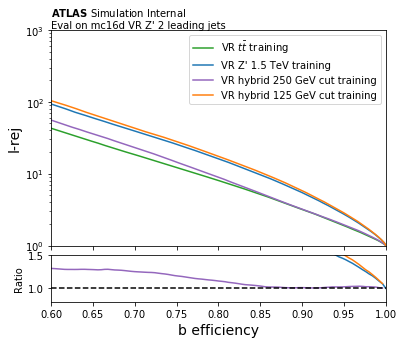

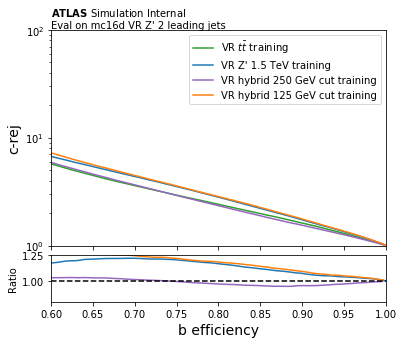

In [10]:
ntests = [np.sum(ys[4]==label) for label in range(3) ]

subDir = 'mc16d_VR_Zprime_1.5TeV_2lead'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR Z' 2 leading jets"

plotROCRatio(beffs[4:], leffs[4:], 
             train_labels, rrange=(0.8,1.5),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROCRatio(beffs[4:], ceffs[4:], 
             train_labels, rrange=(0.8,1.25),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag)

l (0, 150)
c (0, 10)
b (0, 1)


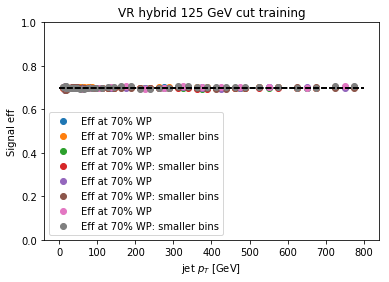

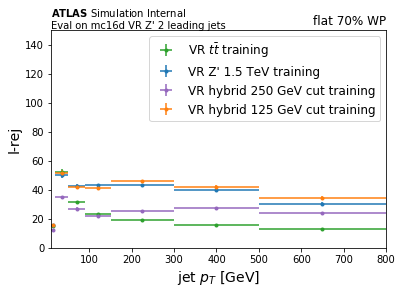

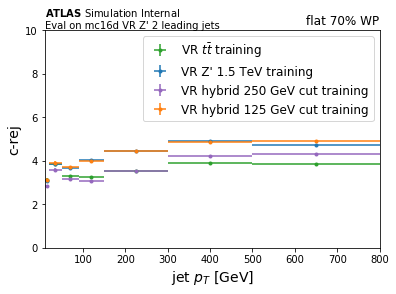

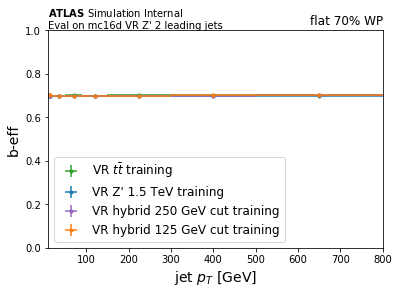

In [11]:
plotPtDependence(pts[4:],ys[4:],discs[4:], train_labels,
                 lrej_lim=(0,150),crej_lim=(0,10),beff_lim=(0,1), verbose=False,
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.array([10,20, 50, 90, 150, 300, 500,800]),
                 eff_bins = np.array([10,12.5,15,17.5,20,30,40,50,70,90,120,150,200,250,300,350,400,450,500,600,700,800]),
                 figDir=figDir,subDir=subDir,tag=plotTag[4:])

l (0, 150)
c (0, 10)
b (0, 1)


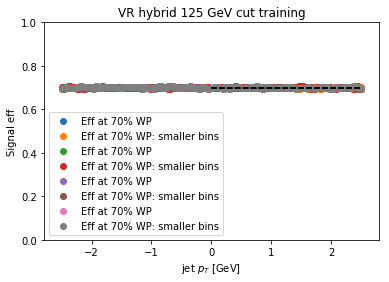

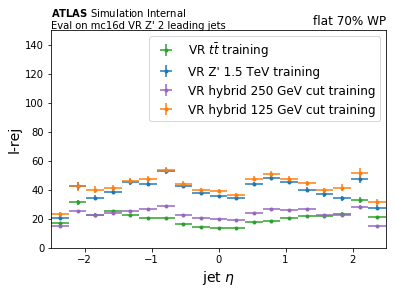

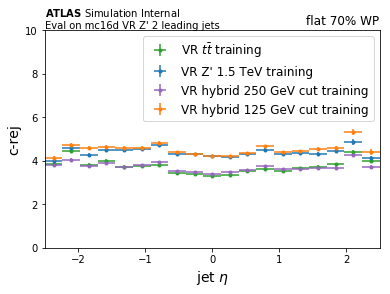

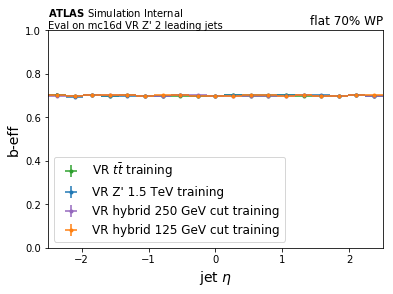

In [12]:
eta_min = -2.5
eta_max =  2.5

plotPtDependence(etas[4:],ys[4:],discs[4:], train_labels, xlabel='jet $\eta$',
                 lrej_lim=(0,150),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),verbose=False,
                 figDir=figDir,subDir=subDir,tag=plotTag[4:], var='eta')

**Lastly...** To show off my improvements for the retraining campaign, I want to overlay with:
1. The EMTopo recommendations
2. The ext hybrid PFlow results eval on VR track jets

Evaluating on ttbar


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


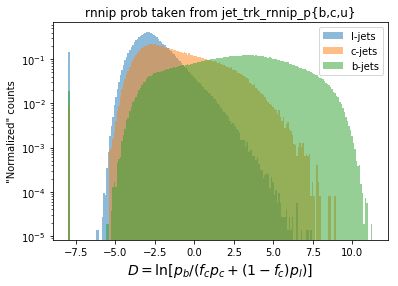

Initialize method from myModel()
Loading previously trained LSTM
min: -12.87, max: 12.85


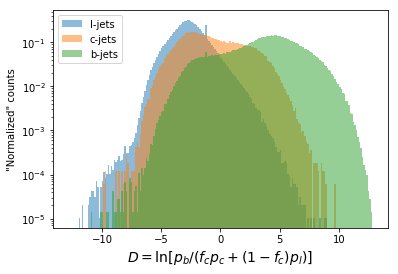

Evaluating on Zprime_1.5TeV


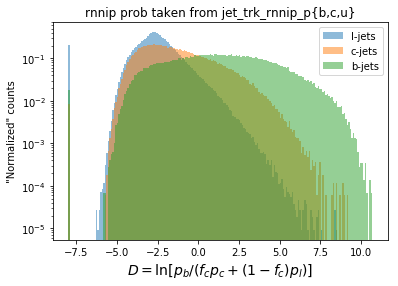

Initialize method from myModel()
Loading previously trained LSTM


KeyboardInterrupt: 

In [14]:
# Save the efficiencies from the previous training in a separate list
cf_leffs, cf_ceffs, cf_beffs, cf_discs = [], [], [], []
fc = 0.07
nBins = 200

for physicsSample, Ntest, nTrks_te in zip(['ttbar','Zprime_1.5TeV'],[int(1.5e6)]*2,[15,25]):
        
    print('Evaluating on '+physicsSample)
        
    # Evaluate Zihao's model
    plt.figure()
        
    # Open the df
    subDir = 'mc16d_{}_{}'.format(jetCollection,physicsSample)
    dataDir = '../../data/'+subDir
    #dataDir = '../../data/mc16d_{}_{}'.format(jetCollection,physicsSample)
    df_tag = '2mtest_15trks_sd0_rev'
    jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')

    disc = np.log(jet_df.rnnip_pb / (fc*jet_df.rnnip_pc + (1-fc)*jet_df.rnnip_pu))
    disc[jet_df.ip3d_ntrk == 0] = -8
    
    myRange = (disc.min(),disc.max())
    
    for pdg, flav in zip([0,4,5],['l','c','b']):

        n,_,_ = plt.hist(disc[jet_df.LabDr_HadF == pdg],
                         bins=nBins,range=myRange, 
                         label="{}-jets".format(flav),
                         alpha = 0.5,
                         density=True, log=True) 

        # Calculate the eff
        eff = calculateEff(n)

        if pdg == 0:
            cf_leffs.append(eff)
        elif pdg == 4:
            cf_ceffs.append(eff)
        elif pdg == 5:
            cf_beffs.append(eff)

    plt.legend()
    plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)
    plt.ylabel('"Normalized" counts')
    plt.title("rnnip prob taken from jet_trk_rnnip_p{b,c,u}")
    plt.show()
    
    # Evaluate my (...) training
    trJetCol = 'PFlow'
    trainPhysicsSample = 'hybrid_5TeV'
    Ntrain = int(5e6)
    nHidden = 400
    nTrks_tr = 15
        
    # Load in the sample for evaluation
    scale_tag = "_{}_{}_scale".format(trJetCol,trainPhysicsSample) 
    dataTagTest = "2mtest_{}trks_{}_sd0_rev{}".format(nTrks_te, vStr, scale_tag)

    f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
    f = h5py.File(f_name,"r")

    X = f['X_test'][:]
    y = f['y_test'][:]
    ix = f['ix_test'][:]

    f.close()

    # If we're evaluating the model that has been trained on 
    nTest = X.shape[0]
    if nTrks_te > nTrks_tr:
        # Restrict the # of tracks you're evaluating with
        X = X[:,:nTrks_tr,:]
    if nTrks_te < nTrks_tr:
        # Append 0s
        zeros = np.zeros((nTest,nTrks_tr-nTrks_te,nFeatures))
        X = np.concatenate((X,zeros),axis=1)

    # Also open the df so that you'll have access to the jet pt and eta
    jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')

    # Load in the model
    modelDir = "../../models/mc16d_{}_{}".format(trJetCol,trainPhysicsSample)
    dataTagTrain = "{}train_{}trks_{}_sd0_rev".format(nJetsTag(Ntrain),nTrks_tr,vStr)
    m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, dataTag=dataTagTrain, loadModel=True)

    # Get the efficiencies
    tag = '_eval_VR_{}_pt_10GeV'.format(physicsSample)
    (leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True,
                                      figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)

    cf_leffs.append(leff)
    cf_ceffs.append(ceff)
    cf_beffs.append(beff)
    cf_discs.append(d)



### $t\bar{t}$ roc curves

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


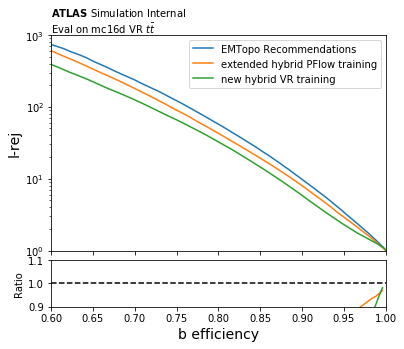

In [19]:
plotROCRatio(beffs[:4], leffs[:4], 
             labels, rrange=(0.9,1.1),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=False)

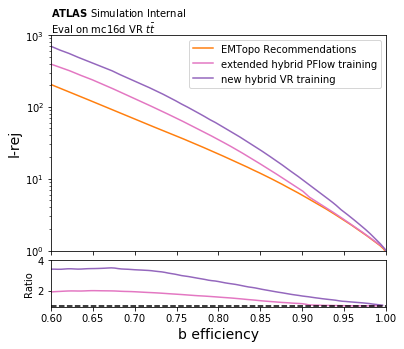

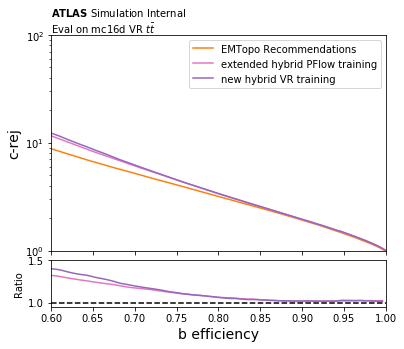

In [23]:
labels=['EMTopo Recommendations','extended hybrid PFlow training','new hybrid VR training']

ntests = [np.sum(ys[0]==label) for label in range(3) ]

subDir = 'mc16d_VR_ttbar'
plotTag = 'rej_moneyPlot'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR $t\bar{t}$"

colors = ['C1','C6','C4']

plotROCRatio(cf_beffs[:2] + [beffs[3]], cf_leffs[:2] + [leffs[3]], 
             labels, rrange=(0.95,4),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROCRatio(cf_beffs[:2] + [beffs[3]], cf_ceffs[:2] + [ceffs[3]], 
             labels, rrange=(0.95,1.5),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag)

### Z' roc curves

In [ ]:
ntests = [np.sum(ys[4]==label) for label in range(3) ]

subDir = 'mc16d_VR_Zprime_2lead'
plotTag = 'rej_moneyPlot'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR $Z'$ 2 leading jets"

plotROCRatio(cf_beffs[2:] + [beffs[7]], cf_leffs + [leffs[3]], 
             train_labels, rrange=(0.9,1.1),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag)

plotROCRatio(cf_beffs[2:] + [beffs[7]], cf_ceffs + [ceffs[3]], 
             train_labels, rrange=(0.9,1.1),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=False,nTest=ntests, 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag)